# Runs Evaluation
This notebook aim to generate report on the runs by comparing the generated runs with the best result we had so far. For each comparison, we will compute different metrics to evaluate the performance of the generated runs. 

---

## Import Required Libraries

Import the necessary libraries, including pandas and matplotlib.


In [138]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Image

from scipy.stats import kendalltau, spearmanr
from wordcloud import WordCloud

## Load the Data
First of all, we need to load the data. We will load the data from the txt file and convert it to a pandas dataframe.

In [139]:
def load_run_file(run_file):
    col_names = ['query_id', '_', 'doc_id', 'rank', 'score', 'team_name', 'xpath']
    df = pd.read_csv(run_file, sep=' ', header=None, names=col_names)
    return df

In [140]:
PLOT_DIR = './plots/'
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Calculate Statistics

We will calculate different statistics for each run.

### Correlation Metrics
The correlation between the run and the best run measures the linear relationship between two rankings. It indicates how well the rankings are related. A higher correlation signifies a stronger linear relationship.

#### Kendall's Tau

Kendall's Tau is a **correlation coefficient** that measures the similarity between two rankings. It considers the number of concordant and discordant pairs of elements between the lists. A positive Tau indicates concordance, meaning that the order of elements is similar, even if not identical. The value ranges from -1 to 1, where 1 implies a perfect match, 0 suggests no correlation, and -1 indicates a perfect inverse match.

#### Spearman's Rank Correlation

Spearman's Rank Correlation is another **measure of monotonic relationship** between two rankings. It assesses how well the relationship between the ranks of elements in the two lists can be described using a monotonic function. Like Kendall's Tau, Spearman's correlation ranges from -1 to 1. A positive value indicates a positive monotonic relationship, and a negative value indicates a negative monotonic relationship.

#### Why Are These Metrics Relevant?

1. **Permutation Tolerance**: Both metrics are robust to variations in the order of elements. In our scenario, where the lists are not identical but might involve permutations or order differences, these metrics provide a comprehensive assessment of similarity.

2. **Non-Linearity Consideration**: Unlike linear correlation metrics, Kendall's Tau and Spearman's Rank Correlation don't assume a linear relationship. This makes them suitable for comparing rankings where the exact position matters more than the magnitude.

By utilizing these metrics, we can have some insights into the degree of similarity between our baseline and test rankings, considering both permutations and order differences.

In [141]:
def calculate_similarity_metrics(df1, df2, max_rows=1500):
    list_baseline = df1['doc_id'].iloc[:max_rows].tolist()
    list_test = df2['doc_id'].iloc[:max_rows].tolist()

    kendall_tau, _ = kendalltau(list_baseline, list_test)
    spearman_corr, _ = spearmanr(list_baseline, list_test)
    
    return kendall_tau, spearman_corr

def plot_similarity_metrics(df1, df2):
    kendall_tau, spearman_corr = calculate_similarity_metrics(df1, df2)
    
    labels = ["Kendall's Tau", "Spearman's Rank Correlation"]
    values = [kendall_tau, spearman_corr]

    plt.bar(labels, values, color=["blue", "green"])
    plt.title("Ranking Similarity Metrics")
    plt.ylabel("Similarity")
    
    # Add exact values on each bar
    for i, v in enumerate(values):
        plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
    
    plt.savefig(PLOT_DIR + "similarity_metrics.png")  # Save the graph
    plt.show()
    
    
def plot_evolutions_of_correlation(df1, df2):
    k_values = [100 * i for i in range(1, 105)]

    correlation_metrics = {}
    for k in k_values:
        kendall_tau, spearman_corr = calculate_similarity_metrics(df1, df2, k)
        correlation_metrics[k] = [kendall_tau, spearman_corr]
        
    plt.figure(figsize=(10, 6))

    plt.plot(k_values, [value[0] for value in correlation_metrics.values()], label='Kendall Tau')
    plt.plot(k_values, [value[1] for value in correlation_metrics.values()], label='Spearman Correlation')

    mean_kendall_tau = np.mean([value[0] for value in correlation_metrics.values()])
    mean_spearman_corr = np.mean([value[1] for value in correlation_metrics.values()])
    
    plt.axhline(mean_kendall_tau, color='red', linestyle='--', label='Mean Kendall Tau')
    plt.axhline(mean_spearman_corr, color='red', linestyle=':', label='Mean Spearman Correlation')

    plt.xlabel('K Values')
    plt.ylabel('Metrics')
    
    plt.title('Correlation Metrics Evolution')
    plt.legend()

    # Annotate mean values on the plot
    plt.text(-550, mean_kendall_tau, f'{mean_kendall_tau:.2f}', color='red', ha='right', va='center')
    plt.text(-550, mean_spearman_corr, f'{mean_spearman_corr:.2f}', color='red', ha='right', va='center')
    
    # Shade the area between mean Kendall Tau and mean Spearman Correlation lines
    plt.fill_between(k_values, [mean_kendall_tau] * len(k_values), [mean_spearman_corr] * len(k_values), color='lightgrey')
    
    plt.savefig(PLOT_DIR + "correlation_metrics_evolution.png")

### Difference

We will now compute the stats on the differences, such as the number of changes, the percentage of changes, or the average change magnitude.

1. Number of Changes: This statistic represents the total count of differences between the two DataFrames. It indicates how many values in the third column of the DataFrames differ from each other.

2. Percentage of Changes: This statistic calculates the percentage of changes in the third column of the DataFrames. It is calculated by dividing the number of changes by the total number of values in the third column and multiplying by 100. It provides a measure of the overall impact of the differences.

3. Average Change Magnitude: This statistic calculates the average magnitude of the changes in the third column of the DataFrames. It represents the average absolute difference between the corresponding values in the two DataFrames. It gives an indication of the typical size of the differences.


In [142]:
def difference_in_ranking(df1, df2, max_rows=1500):
    differences = df1['doc_id'].iloc[:max_rows].compare(df2['doc_id'].iloc[:max_rows])
    number_of_differences = len(differences)
    
    percentage_of_differences = number_of_differences / max_rows * 100
    
    return number_of_differences, percentage_of_differences

def plot_difference_stats(df1, df2):
    number_of_differences, percentage_of_differences = difference_in_ranking(df1, df2)

    labels = ["Number of differences", "Percentage of differences"]
    values = [number_of_differences, percentage_of_differences]

    plt.bar(labels, values, color=["blue", "green"])
    plt.title("Ranking Differences")
    plt.ylabel("Differences")
    
    for i in range(len(labels)):
        plt.text(labels[i], values[i], str(values[i]), ha='center', va='bottom')
    
    plt.savefig(PLOT_DIR + "difference_metrics.png")  # Save the plot
    plt.show()
    
def plot_evolutions_of_difference(df1, df2):
    k_values = [100 * i for i in range(1, 105)]

    difference_metrics = {}
    for k in k_values:
        number_of_differences, percentage_of_differences = difference_in_ranking(df1, df2, k)
        difference_metrics[k] = [number_of_differences, percentage_of_differences]

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, [value[1] for value in difference_metrics.values()], label='Percentage of Differences')

    plt.xlabel('K Values')
    plt.ylabel('Metrics')

    plt.title('Difference Metrics Evolution')
    plt.legend()
    
    plt.savefig(PLOT_DIR + "difference_metrics_evolution.png")  # Save the plot

### XPath Analysis

The point of this analysis is to see wich tag is the most present in the generated runs. We will use the XPath to do so. We will use the XPath to extract the tag from the generated runs and then we will count the number of occurence of each tag.

In [143]:
def compute_tag_frequency(df, max_rows=10500):
    tag_frequency = {}
    for xpath in df['xpath'].iloc[:max_rows]:
        tag = re.sub(r'\[\d+\]', '', xpath).split("/")[-1]
        if tag not in tag_frequency:
            tag_frequency[tag] = 1
        else:
            tag_frequency[tag] += 1
                
    return tag_frequency

def plot_tag_frequency(df1, df2):
    tag_frequency_baseline = compute_tag_frequency(df1)
    tag_frequency_test = compute_tag_frequency(df2)
    
    plt.figure(figsize=(10, 6))
    plt.bar(tag_frequency_baseline.keys(), tag_frequency_baseline.values(), label='Baseline')
    plt.bar(tag_frequency_test.keys(), tag_frequency_test.values(), alpha=0.7, label='Test')
    
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    
    plt.title('Tag Frequency')
    plt.legend()    

    # Add exact values on each bar
    for tag, freq in tag_frequency_baseline.items():
        plt.text(tag, freq, str(freq), ha='center', va='bottom')
    
    for tag, freq in tag_frequency_test.items():
        plt.text(tag, freq, str(freq), ha='center', va='bottom')
    
    plt.savefig(PLOT_DIR + "tag_frequency.png")  # Save the plot
    plt.show()
    
def plot_evolution_of_tag_frequency(df1):
    k_values = [100 * i for i in range(1, 105)]

    tag_frequency_metrics = {}
    for k in k_values:
        tag_frequency = compute_tag_frequency(df1, k)
        
        for tag in set(list(tag_frequency.keys())):
            if tag not in tag_frequency_metrics:
                tag_frequency_metrics[tag] = []
            
            tag_frequency_metrics[tag].append(tag_frequency[tag])

    plt.figure(figsize=(10, 6))

    min_length = min(len(frequencies) for frequencies in tag_frequency_metrics.values())
    k_values = k_values[:min_length]  # Limit k_values to the minimum length

    for tag, frequencies in tag_frequency_metrics.items():
        plt.plot(k_values, frequencies[:min_length], label=tag)
        
    plt.xlabel('K Values')
    plt.ylabel('Frequency')

    plt.title('Tag Frequency Evolution')
    plt.legend()
    
    plt.savefig(PLOT_DIR + "tag_frequency_evolution.png")  # Save the plot



In [144]:
class MetricsGenerator:
    def __init__(self, baseline_df, test_df):
        self.baseline_df = baseline_df
        self.test_df = test_df
        
        self.max_rows = 1500
        
    def generate_metrics(self):
        self.correlation_metrics = self._calculate_correlation_metrics()
        self.difference_metrics = self._calculate_difference_metrics()
        self.tag_frequency = self._compute_tag_frequency(self.test_df)
        
    def _calculate_correlation_metrics(self):
        kendall_tau, spearman_corr = calculate_similarity_metrics(self.baseline_df, self.test_df, max_rows=self.max_rows)
        return {"Kendall's Tau": kendall_tau, "Spearman's Rank Correlation": spearman_corr}
    
    def _calculate_difference_metrics(self):
        number_of_differences, percentage_of_differences = difference_in_ranking(self.baseline_df, self.test_df, max_rows=self.max_rows)
        return {"Number of differences": number_of_differences, "Percentage of differences": percentage_of_differences}
    
    def _compute_tag_frequency(self, df):
        return compute_tag_frequency(test_df)
    
    def generate_plots(self):
        plot_similarity_metrics(self.baseline_df, self.test_df)
        plot_difference_stats(self.baseline_df, self.test_df)
        plot_tag_frequency(baseline_df, test_df)
        
    def generate_evolutions(self):
        plot_evolutions_of_correlation(self.baseline_df, self.test_df)
        plot_evolutions_of_difference(self.baseline_df, self.test_df)
        plot_evolution_of_tag_frequency(self.test_df)


In [160]:
class PdfReport:
    def __init__(self, title, baseline_df, test_df, baseline_run, test_run):
        self.title = title

        self.baseline_df = baseline_df
        self.test_df = test_df
        
        self.baseline_run = baseline_run
        self.test_run = test_run

        self.metric_generator = MetricsGenerator(self.baseline_df, self.test_df)
        
    def generate_report(self, filename):
        self.metric_generator.generate_metrics()
        self.metric_generator.generate_plots()
        self.metric_generator.generate_evolutions()
        
        doc = SimpleDocTemplate(filename, pagesize=letter)
        elements = self._create_elements()
        doc.build(elements)
        
    def _create_elements(self):
        elements = []
        styles = getSampleStyleSheet()

        elements.extend(self._generate_title(styles))
        elements.extend(self._generate_abstract(styles))
        elements.extend(self._generate_correlation_section(styles))
        elements.extend(self._generate_difference_section(styles))
        elements.extend(self._generate_tag_frequency_section(styles))
        
        return elements
    
    def _generate_title(self, styles):
        return [Paragraph(self.title, styles['Title']), Spacer(1, 12)]
    
    def _generate_abstract(self, styles):
        abstract_text = f"This report compares the results of two different runs on the same query set. <br/><br/><b>Baseline run:</b> {self.baseline_run}<br/><b>Test run:</b> {self.test_run}."
        
        return [Paragraph("<i>Abstract:</i> " + abstract_text, styles['Normal']), Spacer(1, 12)]
    
    def _generate_correlation_section(self, styles):
        correlation_section = [Paragraph("<b>Correlation Metrics</b>", styles['Heading1']), Spacer(1, 6)]
        correlation_text = f"<b>Kendall's Tau</b> and <b>Spearman's Rank Correlation</b> are two metrics that measure the similarity between two rankings. The values of these metrics are shown below. <br/>The correlation metrics are calculated using the first <b>{self.metric_generator.max_rows}</b> documents of the ranking."
        correlation_section.append(Paragraph("<i>Correlation Metrics:</i> " + correlation_text, styles['Normal']))
        
        correlation_section.append(Spacer(1, 12))
        
        txt = f"<i>Exact values:</i><br/>"
        correlation_section.append(Paragraph(txt, styles['Normal']))
        
        correlation_section.append(Spacer(1, 12))
        
        correlation_table = MetricsTable(self.metric_generator.correlation_metrics)
        correlation_section.extend(correlation_table.create_table())
        
        # continue the section in a new page
        correlation_section.append(Spacer(1, 12))
        correlation_section.append(Paragraph("<i>Correlation Metrics Evolution:</i>", styles['Normal']))
        txt = f"Let's observe how the correlation metrics evolve as we consider more documents in the ranking. <br/>Larger values of <b>K</b> means that more documents are considered in the ranking. The evolution of the correlation metrics is shown below."
        correlation_section.append(Paragraph(txt, styles['Normal']))
        correlation_section.append(Image(PLOT_DIR + "correlation_metrics_evolution.png", width=500, height=300))
    
        return correlation_section
    
    def _generate_difference_section(self, styles):
        difference_section = [Paragraph("<b>Difference Metrics</b>", styles['Heading1']), Spacer(1, 12)]
        difference_text = f"The difference metrics are calculated using the first <b>{self.metric_generator.max_rows}</b> documents of the ranking."
        
        difference_section.append(Paragraph(difference_text, styles['Normal']))
        difference_section.append(Spacer(1, 12))
        
        difference_table = MetricsTable(self.metric_generator.difference_metrics)
        difference_section.extend(difference_table.create_table())
        
        difference_section.append(Spacer(1, 12))
        difference_section.append(Paragraph("<i>Difference Metrics Evolution:</i>", styles['Normal']))
        txt = f"Let's observe how the difference metrics evolve as we consider more documents in the ranking. <br/>Larger values of <b>K</b> means that more documents are considered in the ranking. The evolution of the difference metrics is shown below."
        
        difference_section.append(Paragraph(txt, styles['Normal']))
        difference_section.append(Image(PLOT_DIR + "difference_metrics_evolution.png", width=500, height=300))
        difference_section.append(PageBreak())
        
        return difference_section
    
    def _generate_tag_frequency_section(self, styles):
        tag_frequency_section = [Paragraph("<b>Tag Frequency</b>", styles['Heading1']), Spacer(1, 12)]
        tag_frequency_text = f"The tag frequency is calculated on the whole ranking. <br/>In this section we will try to indentify the tags that are more frequent in the test run."
        
        tag_frequency_section.append(Paragraph(tag_frequency_text, styles['Normal']))
        tag_frequency_section.append(Image(PLOT_DIR + "tag_frequency.png", width=500, height=250))
        
        # tags that are present in more than 10% of the results
        tag_frequency = self.metric_generator.tag_frequency
        tags_to_consider = [tag for tag, freq in tag_frequency.items() if freq / len(test_df) >= 0.1]
        
        
        txt = f"Let's say we should only consider the tags that are present in more than <b>10%</b> of the results. Then we should only consider the following tags: " + "".join([f"<b>{tag}</b>, " for tag in tags_to_consider])[:-2]
        tag_frequency_section.append(Paragraph(txt, styles['Normal']))
        
        tag_frequency_section.append(Spacer(1, 6))
                
        tag_frequency_section.append(Paragraph("<i>Tag Frequency Evolution:</i>", styles['Normal']))
        txt = f"The objective is to be sure the evolution of the tag frequency is linear, which means that the data is not biased by a particular tag."
        
        tag_frequency_section.append(Paragraph(txt, styles['Normal']))
        tag_frequency_section.append(Image(PLOT_DIR + "tag_frequency_evolution.png", width=500, height=250))
        
        return tag_frequency_section

In [146]:
class MetricsTable:
    def __init__(self, metrics):
        self.metrics = metrics
    
    def create_table(self):
        data = self._get_metrics_data()
        table = Table(data, colWidths=[300, 100])  
        
        # Apply table styling
        table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey),  # Header background color
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),  # Header text color
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('SIZE', (0, 0), (-1, 0), 12),  # Font size for header
            ('LINEABOVE', (0, 0), (-1, 0), 1, colors.black),  # Header line above
            ('LINEBELOW', (0, 0), (-1, 0), 1, colors.black),  # Header line below
            ('BACKGROUND', (0, 1), (-1, -1), colors.white),  # Content background color
            ('GRID', (0, 0), (-1, -1), 1, colors.black),  # Table grid color
        ]))
        
        return [table]
    
    def _get_metrics_data(self):
        metrics_data = [['Metric', 'Value']]  # Header row
        for metric, value in self.metrics.items():
            metrics_data.append([metric, f'{value:.4f}'])  # Data rows
        return metrics_data

In [170]:
baseline_run_name = "BengezzouIdrissMezianeGhilas_15_bm25_bdy_stop671_porter.txt"
test_run_name = "BengezzouIdrissMezianeGhilas_16_bm25_article_stop671_porter_k1.2_b0.75.txt"

baseline_df = load_run_file("../docs/practice_05_v2/resources/" + baseline_run_name)
test_df = load_run_file("../docs/practice_05_v4/resources/" + test_run_name)

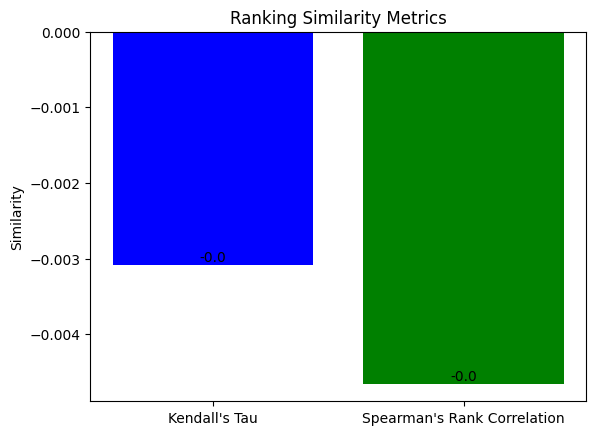

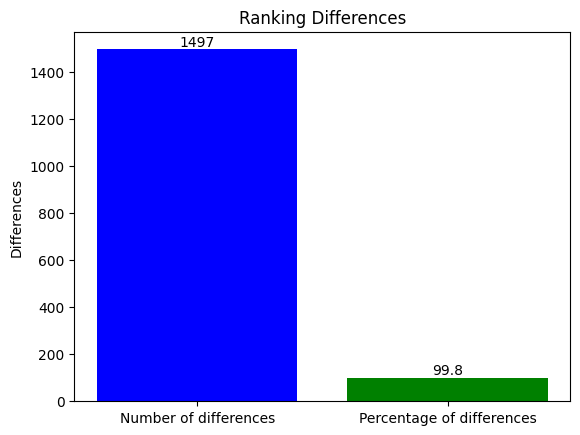

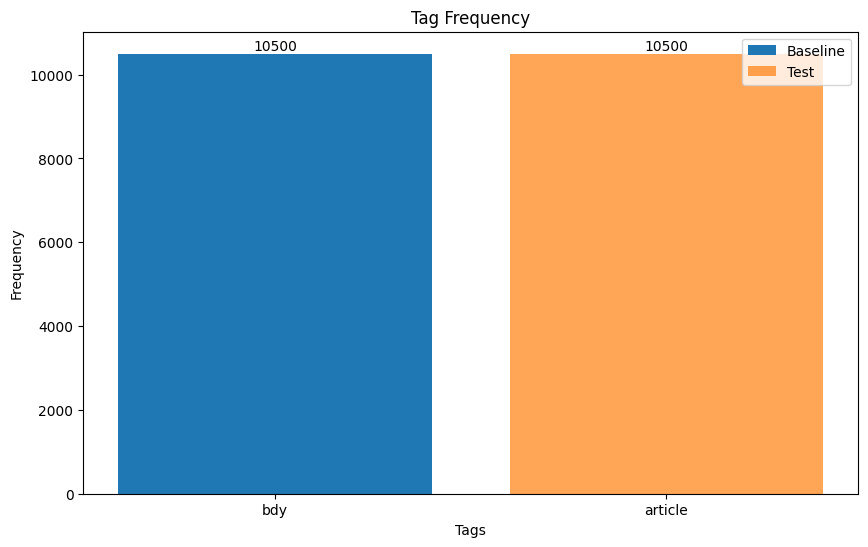

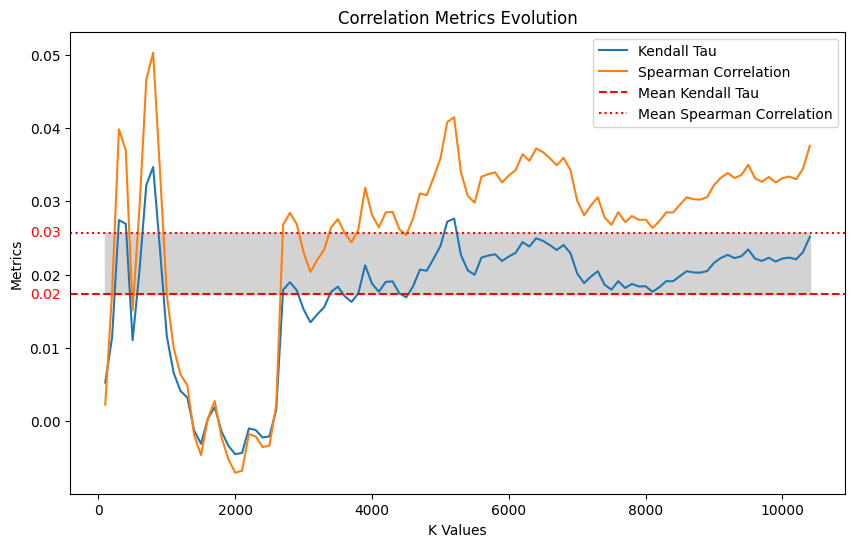

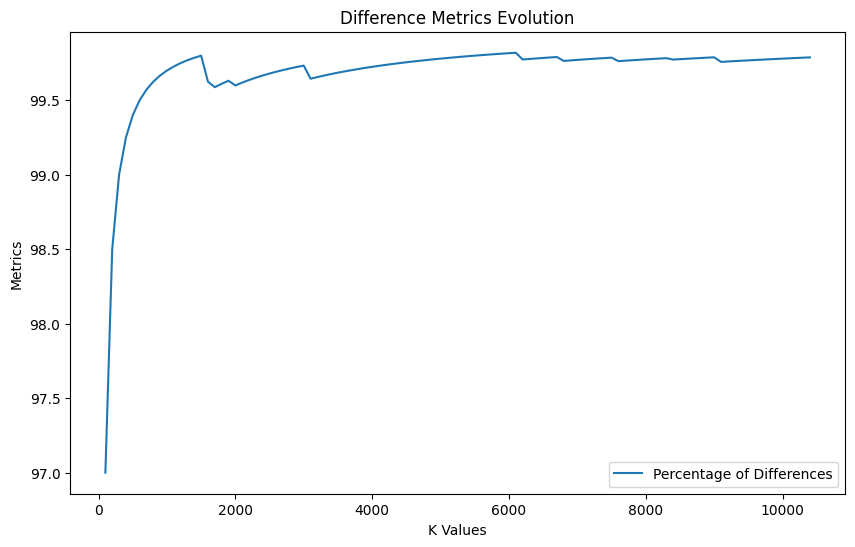

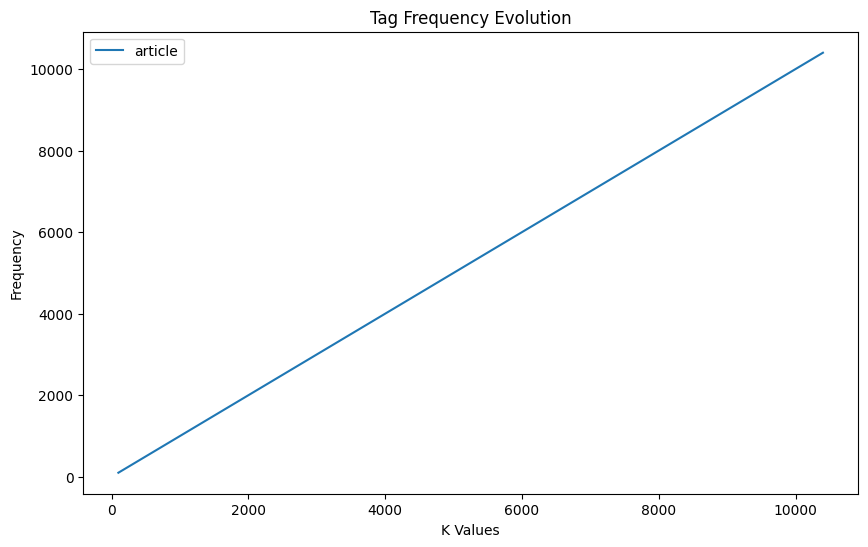

In [171]:
title = "Comparison Report"

OUTPUT_DIR = '../docs/resources/reports/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

report_name = test_run_name.split('.')[0].replace("BengezzouIdrissMezianeGhilas", "")
report_name = "comparison_report" + report_name + '.pdf'

# Create the PDF report
pdf_report = PdfReport(title, baseline_df, test_df, baseline_run_name, test_run_name)
pdf_report.generate_report(OUTPUT_DIR + report_name)